<a href="https://colab.research.google.com/github/danteaguirreb/machine_learning/blob/tareas/CESFAM_El_Monte_NoShow_Modelo_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# CESFAM El Monte — Análisis de Datos y Modelo de Riesgo de No Asistencia (No‑Show)

Este cuaderno sigue la estructura de **Fundamentos de Data Science: Análisis y Modelado** y está aplicado
a los datos de gestión de citas y atenciones del **CESFAM El Monte**.


## 1. Librerías y configuración

In [21]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import unicodedata
import re

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, confusion_matrix
)

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

RANDOM_STATE = 42

print("Librerías cargadas correctamente.")


Librerías cargadas correctamente.



## 2. Carga de datos y diccionario inicial

Definimos rutas y cargamos:

- **Tablero de citas** (`board.csv`).
- **Atenciones efectivamente realizadas** (reportes SIGGES por mes).


In [22]:

from pathlib import Path

BASE_DIR = Path(".")  # ajustar si es necesario

path_board = BASE_DIR / "board.csv"
archivos_atenciones = [
    BASE_DIR / "atenciones de julio.xls",
    BASE_DIR / "agosto.xls",
    BASE_DIR / "octubre y noviembre.xlsx",
    BASE_DIR / "nov y dic.xls",
]

print("Ruta tablero:", path_board)
print("Archivos de atenciones:")
for p in archivos_atenciones:
    print(" -", p)


Ruta tablero: board.csv
Archivos de atenciones:
 - atenciones de julio.xls
 - agosto.xls
 - octubre y noviembre.xlsx
 - nov y dic.xls


### 2.1 Funciones auxiliares de carga y normalización

In [23]:

def normalizar_cols(cols: pd.Index) -> pd.Index:
    return (
        cols.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("á", "a")
        .str.replace("é", "e")
        .str.replace("í", "i")
        .str.replace("ó", "o")
        .str.replace("ú", "u")
        .str.replace("ñ", "n")
    )

def cargar_board(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = normalizar_cols(df.columns)
    return df

def cargar_atenciones_sigges(path: Path, fila_encabezado: int = 8) -> pd.DataFrame:
    try:
        raw = pd.read_excel(path, header=None)
    except Exception as e:
        print(f"ERROR: No se pudo cargar {path.name}: {e}")
        return None
    headers = list(raw.iloc[fila_encabezado])
    df = raw.iloc[fila_encabezado + 1:].copy()
    df.columns = headers
    if "N°" in df.columns:
        df = df[df["N°"].notna()].copy()
    df.columns = normalizar_cols(df.columns)
    return df

def normalizar_nombre(texto: str) -> str:
    if pd.isna(texto):
        return np.nan
    texto = str(texto).upper().strip()
    texto = "".join(
        c for c in unicodedata.normalize("NFKD", texto)
        if not unicodedata.combining(c)
    )
    texto = re.sub(r"[^A-ZÑ ]+", " ", texto)
    texto = re.sub(r"\s+", " ", texto).strip()
    return texto

def clasificar_programa(x: str) -> str:
    if pd.isna(x):
        return "Otro"
    x = str(x).lower()
    if "mental" in x:
        return "Salud Mental"
    if "kine" in x:
        return "Kinesiologia"
    if "cronic" in x:
        return "Cronicos"
    if "control" in x:
        return "Control"
    if "odont" in x:
        return "Odontologia"
    if "proced" in x or "procedim" in x:
        return "Procedimientos"
    return "Otro"

print("Funciones auxiliares definidas.")


Funciones auxiliares definidas.


### 2.2 Cargar board y atenciones SIGGES

In [24]:

board = cargar_board(path_board)
print("board (citas):", board.shape)
display(board.head())

atenciones_list = []
for path in archivos_atenciones:
    if path.exists():
        print(f"Cargando atenciones desde: {path.name}")
        tmp = cargar_atenciones_sigges(path)
        if tmp is not None:
            tmp["archivo_origen"] = path.name
            atenciones_list.append(tmp)
    else:
        print(f"ADVERTENCIA: no se encontró {path.name}, se omite.")

if atenciones_list:
    atenciones = pd.concat(atenciones_list, ignore_index=True)
else:
    atenciones = pd.DataFrame()

print("atenciones (SIGGES):", atenciones.shape)
display(atenciones.head())


board (citas): (22235, 19)


,id,asignado,supervisor,id_interno,fecha_y_hora_cita,profesional,especialidad,direccion_prestador,motivo_suspension,sucursal,area_de_atencion,programa,rut,nombre_del_paciente,celular_1,correo_1,estado,fecha_de_creacion,fecha_de_actualizacion
0,6156456,NaN,Natalia Díaz Justo,NaN,03/12/2025 17:00:00,Marisol Hernandez,Técnico Paramédico,NaN,NaN,AMARILLO,Electrocardiograma,NaN,NaN,Luisa Carmen Ortiz Velasquez,5.698733e+10,NaN,Agendadas,28/11/2025,01/12/2025
1,6156455,NaN,Natalia Díaz Justo,NaN,03/12/2025 08:00:00,Pablo Daniel Vargas,Psicólogo(a),NaN,NaN,AMARILLO,CONSULTA SALUD MENTAL ADULTO,NaN,NaN,Rosa Angelica Bello Muñoz,5.695942e+10,NaN,Agendadas,28/11/2025,02/12/2025
2,6156454,NaN,Natalia Díaz Justo,NaN,03/12/2025 11:40:00,Jeannette Maritza Sepulveda,Enfermero(a),NaN,NaN,AMARILLO,CONTROL INTEGRAL ECICEP,NaN,NaN,Maria Angelica Hernandez Catalan,5.696841e+10,NaN,Agendadas,28/11/2025,01/12/2025
3,6156453,NaN,Natalia Díaz Justo,NaN,03/12/2025 11:00:00,Claudia Meza,Kinesiólogo(a),NaN,NaN,AMARILLO,Consulta kinesica Sala ERA,NaN,NaN,Alejandro Bravo Saavedra,5.699122e+10,NaN,Confirmadas,28/11/2025,01/12/2025
4,6156452,NaN,Natalia Díaz Justo,NaN,03/12/2025 11:20:00,Franco González,Médico,NaN,NaN,AMARILLO,CONTROL INTEGRAL ECICEP,NaN,NaN,Laura Clotilde Herrera Villalon,5.694479e+10,NaN,Agendadas,28/11/2025,01/12/2025


Cargando atenciones desde: atenciones de julio.xls
ERROR: No se pudo cargar atenciones de julio.xls: Excel file format cannot be determined, you must specify an engine manually.
Cargando atenciones desde: agosto.xls
ERROR: No se pudo cargar agosto.xls: Excel file format cannot be determined, you must specify an engine manually.
Cargando atenciones desde: octubre y noviembre.xlsx
Cargando atenciones desde: nov y dic.xls
ERROR: No se pudo cargar nov y dic.xls: Excel file format cannot be determined, you must specify an engine manually.
atenciones (SIGGES): (83470, 27)


,n°,estado_atencion,fecha_consulta,duracion,rendimiento,fecha_cita,tipo_de_atencion,sector,sector_cita,funcionario,instrumento,run,paciente,ciclo_vital,anos,meses,dias,sexo,prevision,actividad_y/o_procedimiento,cantidad,diagnostico,diagnostico_(nuevo_o_repetido),estado_dg,auge,problema_de_salud,archivo_origen
0,1,Cerrada,2025-09-01 07:39:14,270,20,2025-09-01 07:30:00,Otras Morbilidades,AZUL,UNIVERSAL,Isidora Verónica Oportus Molina,Médico,9443040-2,Dagoberto Ricardo Villablanca Hernández,No Aplica,62,3,24,Hombre,Fonasa,Consulta Otras Morbilidades,1,"Diabetes mellitus insulinodependiente, con com...",Repetida,Confirmado,NO,NaN,octubre y noviembre.xlsx
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Otras anemias megaloblásticas, no clasificadas...",Repetida,Confirmado,NO,NaN,octubre y noviembre.xlsx
2,2,Cerrada,2025-09-01 07:49:52,47,40,2025-09-01 08:00:00,CONSULTA SALUD MENTAL INFANTO JUVENIL,AMARILLO,AZUL,FELIPE ANDRES LEAL RAVANAL,Psicólogo(a),24332695-8,Dante Bastián Araos Bravo,No Aplica,12,1,18,Hombre,Fonasa,Controles Salud Mental,1,"Trastorno de ansiedad, no especificado",Repetida,Confirmado,NO,NaN,octubre y noviembre.xlsx
3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Trastorno hipercinético de la conducta,Repetida,Confirmado,NO,NaN,octubre y noviembre.xlsx
4,3,Abierta,2025-09-01 07:52:03,0,20,2025-09-01 07:50:00,Otras Morbilidades,AMARILLO,UNIVERSAL,Javiera Aguilar Danon,Médico,19956147-2,Daniela Elizabeth Vera Bustos,No Aplica,27,3,8,Mujer,Fonasa,Consulta Otras Morbilidades,1,Alergia no especificada,Nueva,Sospecha,NO,NaN,octubre y noviembre.xlsx


## 3. Limpieza básica, tipos de datos y nulos

In [25]:

df_board = board.copy()
df_at = atenciones.copy()

# Fechas en board
if "fecha_y_hora_cita" in df_board.columns:
    df_board["fecha_cita_dt"] = pd.to_datetime(
        df_board["fecha_y_hora_cita"], dayfirst=True, errors="coerce"
    )
else:
    raise KeyError("No se encontró 'fecha_y_hora_cita' en board.")

# Fechas en atenciones
for col in ["fecha_consulta", "fecha_cita"]:
    if col in df_at.columns:
        df_at[f"{col}_dt"] = pd.to_datetime(df_at[col], errors="coerce")

# Categóricas en board
for col in ["estado", "supervisor", "area_de_atencion", "sucursal", "programa"]:
    if col in df_board.columns:
        df_board[col] = df_board[col].astype("category")

# Categóricas en atenciones
for col in ["estado_atencion", "tipo_de_atencion", "sector", "sexo", "prevision"]:
    if col in df_at.columns:
        df_at[col] = df_at[col].astype("category")

print("=== Board (citas) ===")
df_board.info()
print("\n=== Atenciones (SIGGES) ===")
df_at.info()


=== Board (citas) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22235 entries, 0 to 22234
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      22235 non-null  int64         
 1   asignado                1 non-null      object        
 2   supervisor              22235 non-null  category      
 3   id_interno              0 non-null      float64       
 4   fecha_y_hora_cita       17192 non-null  object        
 5   profesional             22235 non-null  object        
 6   especialidad            17193 non-null  object        
 7   direccion_prestador     0 non-null      float64       
 8   motivo_suspension       0 non-null      float64       
 9   sucursal                17206 non-null  category      
 10  area_de_atencion        17192 non-null  category      
 11  programa                259 non-null    category      
 12  rut                     

In [26]:

def resumen_nulos(df: pd.DataFrame, nombre: str):
    pct_null = df.isna().mean().sort_values(ascending=False)
    print(f"\n=== Porcentaje de nulos en {nombre} ===")
    display(pct_null.to_frame("pct_nulos").head(25))

resumen_nulos(df_board, "board (citas)")
resumen_nulos(df_at, "atenciones (SIGGES)")



=== Porcentaje de nulos en board (citas) ===


,pct_nulos
id_interno,1.000000
correo_1,1.000000
motivo_suspension,1.000000
direccion_prestador,1.000000
rut,1.000000
asignado,0.999955
programa,0.988352
celular_1,0.240837
fecha_cita_dt,0.226805
fecha_y_hora_cita,0.226805



=== Porcentaje de nulos en atenciones (SIGGES) ===


,pct_nulos
problema_de_salud,0.943920
run,0.595052
duracion,0.594992
rendimiento,0.594992
fecha_consulta,0.594992
sector_cita,0.594992
fecha_cita,0.594992
sector,0.594992
tipo_de_atencion,0.594992
instrumento,0.594992


## 4. Descripción estadística y frecuencias

In [27]:

print("=== Descripción numérica - board (citas) ===")
display(df_board.describe(include=[np.number]).T)

print("\n=== Descripción numérica - atenciones (SIGGES) ===")
# Convert potential numeric columns to actual numeric types
for col in ["duracion", "rendimiento", "anos", "meses", "dias", "cantidad"]:
    if col in df_at.columns:
        df_at[col] = pd.to_numeric(df_at[col], errors="coerce")

display(df_at.describe(include=[np.number]).T)


=== Descripción numérica - board (citas) ===


,count,mean,std,min,25%,50%,75%,max
id,22235.0,4.376173e+06,1.114018e+06,2.747481e+06,3.455584e+06,4.136502e+06,5.750050e+06,6.156456e+06
id_interno,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
direccion_prestador,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
motivo_suspension,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rut,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
celular_1,16880.0,5.696412e+10,2.281479e+07,5.690000e+10,5.694565e+10,5.696517e+10,5.698438e+10,5.699998e+10
correo_1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



=== Descripción numérica - atenciones (SIGGES) ===


,count,mean,std,min,25%,50%,75%,max
duracion,33806.0,2105.864669,6966.747040,0.0,8.0,34.0,210.75,110551.0
rendimiento,33806.0,27.672366,17.281736,0.0,15.0,30.0,40.00,180.0
anos,33806.0,45.084038,26.114898,0.0,22.0,49.0,66.00,103.0
meses,33806.0,5.478939,3.580736,0.0,2.0,6.0,9.00,11.0
dias,33806.0,14.500503,8.657368,0.0,7.0,15.0,22.00,30.0
cantidad,74647.0,1.117031,0.685331,1.0,1.0,1.0,1.00,26.0


In [28]:

print("=== Frecuencias categóricas claves (board) ===")
for col in ["estado", "supervisor", "area_de_atencion", "programa", "sucursal"]:
    if col in df_board.columns:
        print(f"\n>>> {col}")
        display(df_board[col].value_counts(dropna=False).to_frame("frecuencia"))


=== Frecuencias categóricas claves (board) ===

>>> estado


,frecuencia
estado,
Confirmadas,7601
Agendadas,6929
Sin responder,5291
Falla envío,1715
Canceladas,450
Canceladas por el centro,246
Respuesta indefinida,3



>>> supervisor


,frecuencia
supervisor,
Natalia Díaz Justo,14843
Ivan Zuñiga,6136
Francisca Ibarra Vera,825
Jose-Emilio Castillo,279
Lorena Muñoz,152



>>> area_de_atencion


,frecuencia
area_de_atencion,
NaN,5043
CONTROL INTEGRAL ECICEP,3975
Operatoria Odontológica,1932
CONSULTA SALUD MENTAL ADULTO,1700
INGRESO SALUD MENTAL ADULTO,649
...,...
Visita Domiciliaria Chile Crece.,1
Radiografia dental,1
Control Adolescente,1



>>> programa


,frecuencia
programa,
NaN,21976
Cancelación masiva,259



>>> sucursal


,frecuencia
sucursal,
NaN,5029
VERDE,4946
AMARILLO,4647
AZUL,4259
ROJO,2893
CECOSF LO CHACON,437
amarillo,18
UNIVERSAL,4
VBERDE,1


In [29]:

print("=== Frecuencias categóricas claves (atenciones) ===")
for col in ["estado_atencion", "tipo_de_atencion", "sector", "sexo", "prevision"]:
    if col in df_at.columns:
        print(f"\n>>> {col}")
        display(df_at[col].value_counts(dropna=False).to_frame("frecuencia"))


=== Frecuencias categóricas claves (atenciones) ===

>>> estado_atencion


,frecuencia
estado_atencion,
NaN,49664
Cerrada,33585
Abierta,221



>>> tipo_de_atencion


,frecuencia
tipo_de_atencion,
NaN,49664
Otras Morbilidades,3535
CONTROL INTEGRAL ECICEP,2631
Atención abreviada,1590
Curación Tratamiento,1481
...,...
Control Cronico Integral,1
Tepsi 3 a 4 años,1
Trazabilidad PAP,1



>>> sector


,frecuencia
sector,
NaN,49664
VERDE,7680
AMARILLO,7175
AZUL,6890
ROJO,6259
CECOSF LO CHACON,5622
No Informado,171
UNIVERSAL,5
NO INFORMADO,4



>>> sexo


,frecuencia
sexo,
NaN,49664
Mujer,21901
Hombre,11899
-,6



>>> prevision


,frecuencia
prevision,
NaN,49664
Fonasa,33661
Seguro Escolar Publico,44
Seguro Escolar Privado,30
Desconocido,24
Ninguna,23
Particular,12
Banmédica S.A.,5
Consalud S.A.,5


### 4.1 Distribuciones univariadas

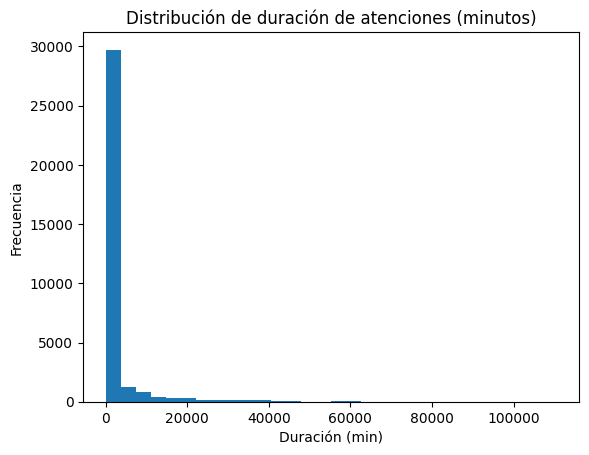

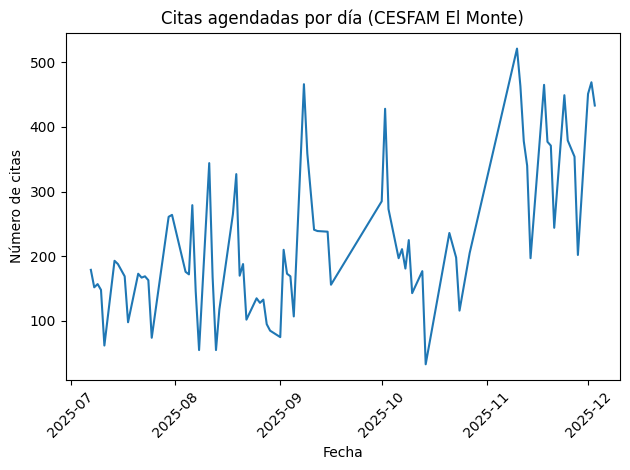

In [30]:

if "años" in df_at.columns:
    plt.figure()
    df_at["años"].dropna().astype(float).plot(kind="hist", bins=30)
    plt.title("Distribución de edad en atenciones (años)")
    plt.xlabel("Edad")
    plt.ylabel("Frecuencia")
    plt.show()

if "duracion" in df_at.columns:
    plt.figure()
    df_at["duracion"].dropna().astype(float).plot(kind="hist", bins=30)
    plt.title("Distribución de duración de atenciones (minutos)")
    plt.xlabel("Duración (min)")
    plt.ylabel("Frecuencia")
    plt.show()

df_board["fecha_cita_dia"] = df_board["fecha_cita_dt"].dt.date
citas_por_dia = df_board.groupby("fecha_cita_dia")["id"].count()
plt.figure()
citas_por_dia.plot()
plt.title("Citas agendadas por día (CESFAM El Monte)")
plt.xlabel("Fecha")
plt.ylabel("Número de citas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5. Análisis bivariado y correlación

Citas por estado:


/tmp/ipython-input-2033066490.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_board.groupby("estado")["id"].count().sort_values(ascending=False).to_frame("n_citas")


,n_citas,pct
estado,,
Confirmadas,7601,0.341848
Agendadas,6929,0.311626
Sin responder,5291,0.237958
Falla envío,1715,0.077131
Canceladas,450,0.020238
Canceladas por el centro,246,0.011064
Respuesta indefinida,3,0.000135


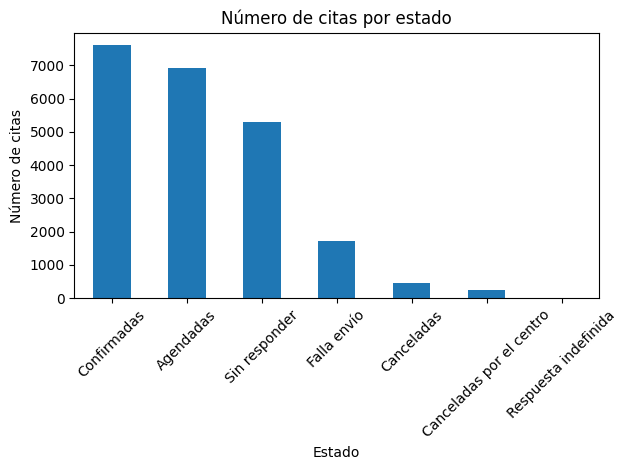


Citas por día de la semana y estado:


/tmp/ipython-input-2033066490.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_board.pivot_table(index="dia_semana_cat", columns="estado", values="id", aggfunc="count")


estado,Agendadas,Canceladas,Canceladas por el centro,Confirmadas,Falla envío,Respuesta indefinida,Sin responder
dia_semana_cat,,,,,,,
Lunes,7.0,139.0,77.0,2456.0,703.0,1.0,861.0
Martes,994.0,82.0,78.0,1666.0,404.0,1.0,1058.0
Miércoles,838.0,39.0,35.0,786.0,46.0,0.0,1307.0
Jueves,47.0,118.0,38.0,1727.0,349.0,1.0,1337.0
Viernes,2.0,72.0,16.0,966.0,213.0,0.0,728.0
Sábado,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Domingo,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Figure size 640x480 with 0 Axes>

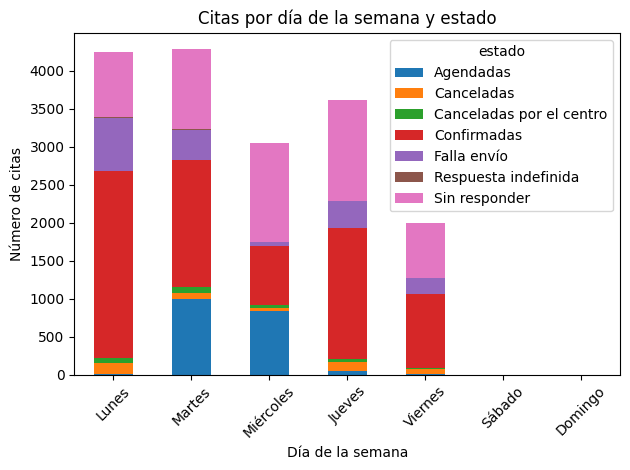

In [31]:

# Citas por estado
if "estado" in df_board.columns:
    tabla_estado = (
        df_board.groupby("estado")["id"].count().sort_values(ascending=False).to_frame("n_citas")
    )
    tabla_estado["pct"] = tabla_estado["n_citas"] / tabla_estado["n_citas"].sum()
    print("Citas por estado:")
    display(tabla_estado)

    plt.figure()
    tabla_estado["n_citas"].plot(kind="bar")
    plt.title("Número de citas por estado")
    plt.xlabel("Estado")
    plt.ylabel("Número de citas")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Día de la semana vs estado
df_board["dia_semana"] = df_board["fecha_cita_dt"].dt.dayofweek
dias_map = {0: "Lunes", 1: "Martes", 2: "Miércoles", 3: "Jueves", 4: "Viernes", 5: "Sábado", 6: "Domingo"}
df_board["dia_semana_cat"] = df_board["dia_semana"].map(dias_map)

if "estado" in df_board.columns:
    tabla_dia_estado = (
        df_board.pivot_table(index="dia_semana_cat", columns="estado", values="id", aggfunc="count")
        .fillna(0)
        .reindex(["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"])
    )
    print("\nCitas por día de la semana y estado:")
    display(tabla_dia_estado)

    plt.figure()
    tabla_dia_estado.plot(kind="bar", stacked=True)
    plt.title("Citas por día de la semana y estado")
    plt.xlabel("Día de la semana")
    plt.ylabel("Número de citas")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Matriz de correlación (atenciones)


,duracion,rendimiento,anos,meses,dias,cantidad
duracion,1.000000,0.195797,-0.033146,-0.004182,-0.003471,0.003736
rendimiento,0.195797,1.000000,0.032549,-0.006427,-0.008966,-0.033442
anos,-0.033146,0.032549,1.000000,0.034443,-0.005766,0.038040
meses,-0.004182,-0.006427,0.034443,1.000000,0.013990,-0.000474
dias,-0.003471,-0.008966,-0.005766,0.013990,1.000000,0.005509
cantidad,0.003736,-0.033442,0.038040,-0.000474,0.005509,1.000000


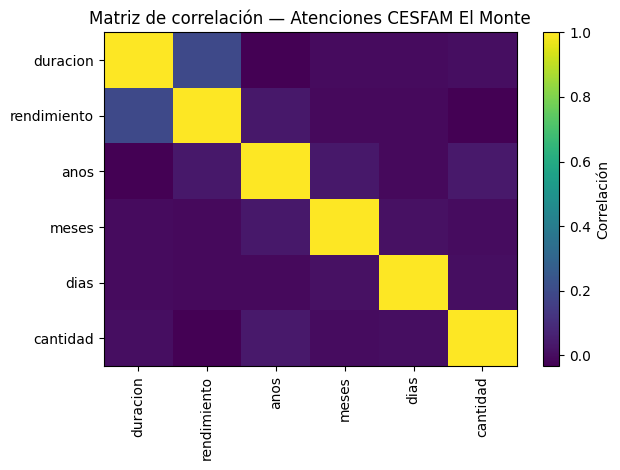

In [32]:

# Matriz de correlación en atenciones
num_cols_at = df_at.select_dtypes(include=[np.number]).columns

if len(num_cols_at) > 0:
    corr_at = df_at[num_cols_at].corr()
    print("Matriz de correlación (atenciones)")
    display(corr_at)

    plt.figure()
    plt.imshow(corr_at, aspect="auto")
    plt.xticks(range(len(num_cols_at)), num_cols_at, rotation=90)
    plt.yticks(range(len(num_cols_at)), num_cols_at)
    plt.colorbar(label="Correlación")
    plt.title("Matriz de correlación — Atenciones CESFAM El Monte")
    plt.tight_layout()
    plt.show()
else:
    print("No hay columnas numéricas suficientes para correlación en atenciones.")


## 6. Cruce entre citas confirmadas y atenciones realizadas

In [33]:

# Normalización de nombres
if "nombre_del_paciente" in df_board.columns:
    df_board["nombre_norm"] = df_board["nombre_del_paciente"].apply(normalizar_nombre)
else:
    raise KeyError("No se encontró 'Nombre del paciente' en board.")

if "paciente" in df_at.columns:
    df_at["nombre_norm"] = df_at["paciente"].apply(normalizar_nombre)
else:
    raise KeyError("No se encontró 'PACIENTE' en atenciones.")

# Clave de tiempo 30min
df_board["clave_cita_30m"] = df_board["fecha_cita_dt"].dt.floor("30min")
if "fecha_cita_dt" in df_at.columns:
    df_at["clave_cita_30m"] = df_at["fecha_cita_dt"].dt.floor("30min")
elif "fecha_consulta_dt" in df_at.columns:
    df_at["clave_cita_30m"] = df_at["fecha_consulta_dt"].dt.floor("30min")
else:
    df_at["clave_cita_30m"] = pd.NaT

# Confirmadas
if "estado" in df_board.columns:
    df_conf = df_board[df_board["estado"].str.contains("confirm", case=False, na=False)].copy()
else:
    df_conf = df_board.copy()

print("Total citas confirmadas:", df_conf.shape[0])

# Atenciones cerradas
if "estado_atencion" in df_at.columns:
    df_real = df_at[df_at["estado_atencion"].str.contains("cerrad", case=False, na=False)].copy()
else:
    df_real = df_at.copy()

print("Total atenciones cerradas:", df_real.shape[0])

cols_real_clave = ["nombre_norm", "clave_cita_30m"]
for extra in ["estado_atencion", "fecha_consulta_dt", "tipo_de_atencion", "sector"]:
    if extra in df_real.columns:
        cols_real_clave.append(extra)

df_match = df_conf.merge(
    df_real[cols_real_clave],
    on=["nombre_norm", "clave_cita_30m"],
    how="left",
    suffixes=("_board", "_real"),
)

df_match["asistio"] = ~df_match["estado_atencion"].isna()
display(df_match[["id", "nombre_del_paciente", "fecha_cita_dt", "estado", "asistio"]].head())


Total citas confirmadas: 7601
Total atenciones cerradas: 33585


,id,nombre_del_paciente,fecha_cita_dt,estado,asistio
0,6156453,Alejandro Bravo Saavedra,2025-12-03 11:00:00,Confirmadas,False
1,6156446,Guzmaro Manuel Barrera Muñoz,2025-12-03 19:40:00,Confirmadas,False
2,6156440,Nelly Jiliberto Ramirez,2025-12-03 14:00:00,Confirmadas,False
3,6156439,Connie Odette Vasquez Cabello,2025-12-03 15:30:00,Confirmadas,False
4,6156427,Agustín Mateo Rodríguez Zúñiga,2025-12-03 12:00:00,Confirmadas,False


### 6.1 Tasas de asistencia por dimensiones de gestión

Tasa de asistencia estimada (sobre confirmadas): 23.60%

Tasa de asistencia por área de atención:


/tmp/ipython-input-783533609.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tasa_area = df_match.groupby("area_de_atencion")["asistio"].mean().sort_values(ascending=False)


,tasa_asistencia
area_de_atencion,
Teledermatologia,1.000000
Gestión Contralor Medico,1.000000
CONSULTA KINESIOLOGICA CAMPAÑA INVIERNO,0.750000
Control Kinésico Sala Ira,0.700000
Ingreso Sala Rehabilitación,0.690476
...,...
control alzheimer y otras demencias,NaN
ingreso alzheimer y otras demencias,NaN
CONSULTA SALUD MENTAL INFANTO JUVENIL,NaN


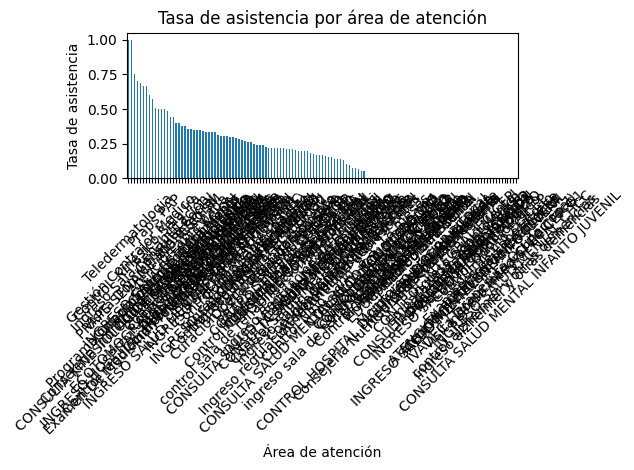


Tasa de asistencia por programa (top 20):


/tmp/ipython-input-783533609.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tasa_prog = df_match.groupby("programa")["asistio"].mean().sort_values(ascending=False)


,tasa_asistencia
programa,
Cancelación masiva,0.076923



Tasa de asistencia por día de la semana:


,tasa_asistencia
dia_semana_cat,
Viernes,0.367409
Lunes,0.271739
Jueves,0.230594
Martes,0.184258
Miércoles,0.081967


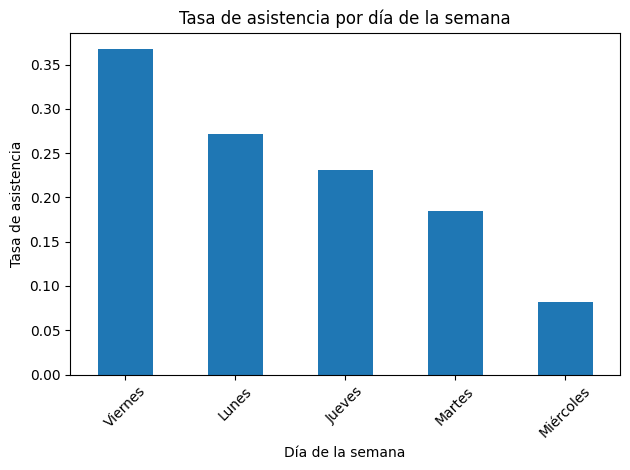

In [34]:

tasa_global = df_match["asistio"].mean()
print(f"Tasa de asistencia estimada (sobre confirmadas): {tasa_global:.2%}")

if "area_de_atencion" in df_match.columns:
    tasa_area = df_match.groupby("area_de_atencion")["asistio"].mean().sort_values(ascending=False)
    print("\nTasa de asistencia por área de atención:")
    display(tasa_area.to_frame("tasa_asistencia"))

    plt.figure()
    tasa_area.plot(kind="bar")
    plt.title("Tasa de asistencia por área de atención")
    plt.xlabel("Área de atención")
    plt.ylabel("Tasa de asistencia")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if "programa" in df_match.columns:
    tasa_prog = df_match.groupby("programa")["asistio"].mean().sort_values(ascending=False)
    print("\nTasa de asistencia por programa (top 20):")
    display(tasa_prog.to_frame("tasa_asistencia").head(20))

if "dia_semana_cat" in df_match.columns:
    tasa_dia = df_match.groupby("dia_semana_cat")["asistio"].mean().sort_values(ascending=False)
    print("\nTasa de asistencia por día de la semana:")
    display(tasa_dia.to_frame("tasa_asistencia"))

    plt.figure()
    tasa_dia.plot(kind="bar")
    plt.title("Tasa de asistencia por día de la semana")
    plt.xlabel("Día de la semana")
    plt.ylabel("Tasa de asistencia")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## 7. Modelo de riesgo de no asistencia (no‑show)

In [35]:

df_model = df_match.copy()
df_model = df_model[df_model["asistio"].notna()].copy()
df_model["no_asiste"] = (~df_model["asistio"]).astype(int)

df_model["hora"] = df_model["fecha_cita_dt"].dt.hour
df_model["mes"] = df_model["fecha_cita_dt"].dt.month
df_model["semana"] = df_model["fecha_cita_dt"].dt.isocalendar().week.astype(int)

df_model["hora_sin"] = np.sin(2 * np.pi * df_model["hora"] / 24)
df_model["hora_cos"] = np.cos(2 * np.pi * df_model["hora"] / 24)

if "fecha_de_creacion" in df_model.columns:
    df_model["fecha_crea_dt"] = pd.to_datetime(df_model["fecha_de_creacion"], errors="coerce")
    df_model["anticipo_dias"] = (df_model["fecha_cita_dt"] - df_model["fecha_crea_dt"]).dt.days
else:
    df_model["anticipo_dias"] = np.nan

df_model["programa_macro"] = df_model["programa"].apply(clasificar_programa)

if "dia_semana_cat" not in df_model.columns:
    df_model["dia_semana"] = df_model["fecha_cita_dt"].dt.dayofweek
    dias_map = {0: "Lunes", 1: "Martes", 2: "Miércoles", 3: "Jueves", 4: "Viernes", 5: "Sábado", 6: "Domingo"}
    df_model["dia_semana_cat"] = df_model["dia_semana"].map(dias_map)

df_model["dia_semana_cat"] = df_model["dia_semana_cat"].fillna("Desconocido")

display(df_model[["fecha_cita_dt", "estado", "asistio", "no_asiste", "dia_semana_cat", "hora", "programa_macro"]].head())


/tmp/ipython-input-674944973.py:13: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_model["fecha_crea_dt"] = pd.to_datetime(df_model["fecha_de_creacion"], errors="coerce")


,fecha_cita_dt,estado,asistio,no_asiste,dia_semana_cat,hora,programa_macro
0,2025-12-03 11:00:00,Confirmadas,False,1,Miércoles,11,NaN
1,2025-12-03 19:40:00,Confirmadas,False,1,Miércoles,19,NaN
2,2025-12-03 14:00:00,Confirmadas,False,1,Miércoles,14,NaN
3,2025-12-03 15:30:00,Confirmadas,False,1,Miércoles,15,NaN
4,2025-12-03 12:00:00,Confirmadas,False,1,Miércoles,12,NaN


### 7.1 Modelo global: entrenamiento y evaluación

In [36]:

features = ["dia_semana_cat", "programa_macro", "hora", "hora_sin", "hora_cos", "mes", "semana", "anticipo_dias"]
for extra_cat in ["area_de_atencion", "sucursal"]:
    if extra_cat in df_model.columns:
        features.append(extra_cat)

X = df_model[features].copy()
y = df_model["no_asiste"].copy()

cat_cols = [c for c in ["dia_semana_cat", "programa_macro", "area_de_atencion", "sucursal"] if c in X.columns]
num_cols = [c for c in features if c not in cat_cols]

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

log_reg = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)

pipe_global = Pipeline(steps=[("prep", pre), ("model", log_reg)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

pipe_global.fit(X_train, y_train)

y_pred = pipe_global.predict(X_test)
y_proba = pipe_global.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1:        {f1:.3f}")
print(f"AUC:       {auc:.3f}")


Accuracy:  0.810
Precision: 0.827
Recall:    0.950
F1:        0.884
AUC:       0.821


Matriz de confusión (filas = real, columnas = predicho)
[[ 195  350]
 [  88 1676]]
TN (asiste y bien predicho):        195
FP (modelo dice no asiste y sí fue): 350
FN (modelo dice asiste y no fue):    88
TP (no asiste y bien predicho):      1676


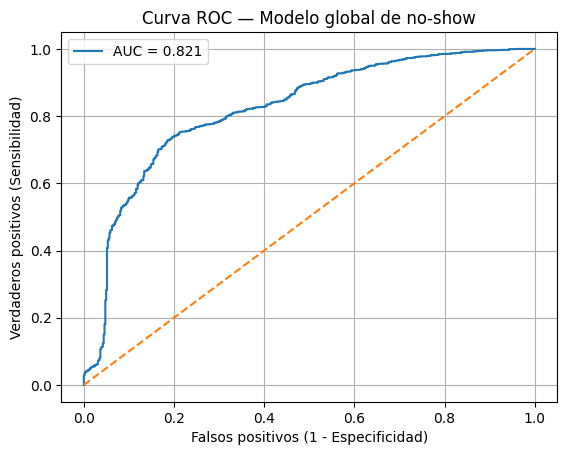

In [37]:

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Matriz de confusión (filas = real, columnas = predicho)")
print(cm)
print(f"TN (asiste y bien predicho):        {tn}")
print(f"FP (modelo dice no asiste y sí fue): {fp}")
print(f"FN (modelo dice asiste y no fue):    {fn}")
print(f"TP (no asiste y bien predicho):      {tp}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Falsos positivos (1 - Especificidad)")
plt.ylabel("Verdaderos positivos (Sensibilidad)")
plt.title("Curva ROC — Modelo global de no‑show")
plt.legend()
plt.grid(True)
plt.show()


### 7.2 Importancia de variables (coeficientes)

Top 20 variables más influyentes (en valor absoluto):


,feature,coef,abs_coef
126,mes,-2.402040,2.402040
3,dia_semana_cat_Miércoles,1.527408,1.527408
33,area_de_atencion_ Control Kinésico Sala Ira,-1.404972,1.404972
43,area_de_atencion_ Control Integral ECICEP G3,1.331504,1.331504
46,area_de_atencion_ Control Prenatal,-1.281036,1.281036
69,area_de_atencion_ Examen De Medicina Preventiv...,-1.156129,1.156129
96,area_de_atencion_ Praps PAP,-1.144172,1.144172
82,area_de_atencion_ Ingreso Sala Rehabilitación,-1.092699,1.092699
54,area_de_atencion_ Control medico Sala IRA,1.070340,1.070340
118,sucursal_CECOSF LO CHACON,1.064344,1.064344


/tmp/ipython-input-3736809335.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


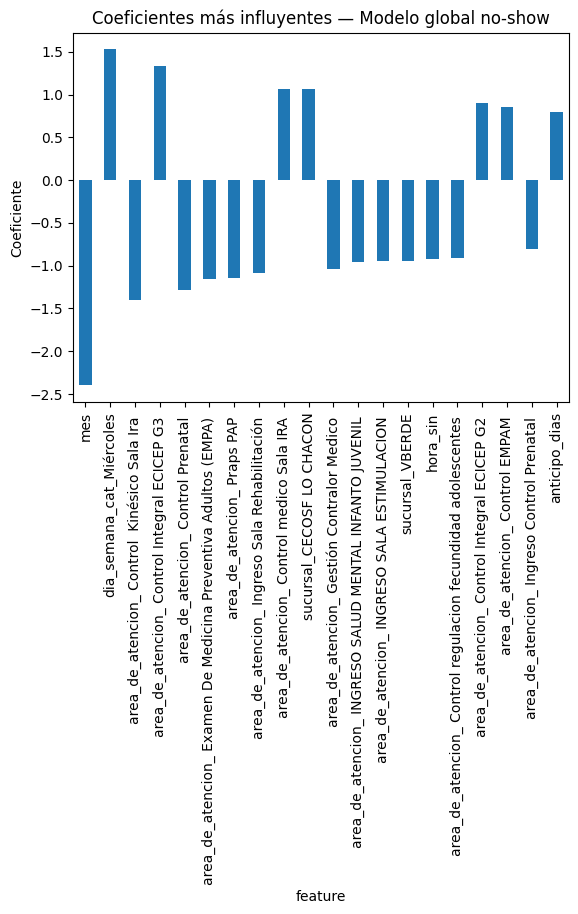

In [38]:

pre = pipe_global.named_steps["prep"]
logreg = pipe_global.named_steps["model"]

cat_transformer = pre.named_transformers_["cat"]
cat_cols_effective = pre.transformers_[0][2]
num_cols_effective = pre.transformers_[1][2]

cat_feature_names = list(cat_transformer.get_feature_names_out(cat_cols_effective))
all_features = cat_feature_names + list(num_cols_effective)

coefs = logreg.coef_[0]
coef_df = pd.DataFrame({"feature": all_features, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

print("Top 20 variables más influyentes (en valor absoluto):")
display(coef_df.head(20))

plt.figure()
coef_df.head(20).set_index("feature")["coef"].plot(kind="bar")
plt.xticks(rotation=90)
plt.title("Coeficientes más influyentes — Modelo global no‑show")
plt.ylabel("Coeficiente")
plt.tight_layout()
plt.show()


# Sección nueva


## 8. Cierre y siguientes pasos

Este cuaderno deja instalado:

- Un **EDA estructurado** de las citas y las atenciones.
- Un cruce reproducible entre **citas confirmadas** y **atenciones cerradas**.
- Un **modelo global de riesgo de no asistencia**, con:
  - Matriz de confusión.
  - Métricas estándar (Accuracy, Precision, Recall, F1, AUC).
  - Curva ROC.
  - Importancia de variables.

Sobre esta base se pueden diseñar reglas de negocio y pilotos de intervención enfocados en
los segmentos de mayor riesgo de no‑show en el CESFAM El Monte.
